## 50단계: 미니배치를 뽑아주는 DataLoader

> Dataset 클래스에서 미니배치를 뽑아주는 DataLoader 클래스를 구현합니다.

### 50.1 반복자란

반복자(iterator)는 원소를 반복하여 꺼내준다.

In [1]:
t = [1, 2, 3]
x = iter(t)
print(next(x))
print(next(x))
print(next(x))
next(x)  # Raises StopIteration

1
2
3


StopIteration: 

In [2]:
# 직접 반복자 만들기

class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt
        self.cnt = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.cnt == self.max_cnt:
            raise StopIteration
        
        self.cnt += 1
        return self.cnt

obj = MyIterator(5)
for x in obj:
    print(x)

1
2
3
4
5


In [3]:
# dezero/dataloaders.py

import math
import numpy as np

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)

        self.reset()

    def reset(self):
        self.iteration = 0  # 반복 횟수 초기화
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset))  # 데이터 뒤섞기
        else:
            self.index = np.arange(len(self.dataset))

    def __iter__(self):
        return self

    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration

        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size:(i + 1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]
        x = np.array([example[0] for example in batch])
        t = np.array([example[1] for example in batch])

        self.iteration += 1
        return x, t

    def next(self):
        return self.__next__()

### 50.2 DataLoader 사용하기

In [4]:
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(max_epoch):
    for x, t in train_loader:
        print(x.shape, t.shape)  # x, t는 훈련 데이터
        break

    # 에포크 끝에서 테스트 데이터를 꺼낸다.
    for x, t in test_loader:
        print(x.shape, t.shape)  # x, t는 테스트 데이터
        break

(10, 2) (10,)
(10, 2) (10,)


### 50.3 accuracy 함수 구현하기

In [5]:
# dezero/functions.py

from dezero import as_variable, Variable, as_array

def accuracy(y, t):
    y, t = as_variable(y), as_variable(t)
    
    pred = y.data.argmax(axis=1).reshape(t.shape)
    result = (pred == t.data)
    acc = result.mean()
    return Variable(as_array(acc))

In [6]:
import numpy as np
import dezero.functions as F

y = np.array([[0.2, 0.8, 0], [0.1, 0.9, 0], [0.8, 0.1, 0.1]])
t = np.array([1, 2, 0])
acc = F.accuracy(y, t)
print(acc)

Variable(0.6666666666666666)


### 50.4 스파이럴 데이터셋 학습 코드

In [7]:
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP


max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)
history = {
    "loss": {"train": [], "test": []},
    "acc": {"train": [], "test": []}
}
for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:  # 1. 훈련용 미니배치 데이터
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)  # 2. 훈련 데이터의 인식 정확도
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    history["loss"]["train"].append(sum_loss / len(train_set))
    history["acc"]["train"].append(sum_acc / len(train_set))
    
    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():  # 3. 기울기 불필요 모드
        for x, t in test_loader:  # 4. 테스트용 미니배치 데이터
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)  # 5. 테스트 데이터의 인식 정확도
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
    
    history["loss"]["test"].append(sum_loss / len(test_set))
    history["acc"]["test"].append(sum_acc / len(test_set))
    
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.0944, accuracy: 0.4033
test loss: 1.0468, accuracy: 0.3267
epoch: 2
train loss: 0.9882, accuracy: 0.4933
test loss: 0.9729, accuracy: 0.4333
epoch: 3
train loss: 0.9403, accuracy: 0.5133
test loss: 0.8965, accuracy: 0.6233
epoch: 4
train loss: 0.8820, accuracy: 0.5700
test loss: 0.8771, accuracy: 0.5967
epoch: 5
train loss: 0.8617, accuracy: 0.5600
test loss: 0.8670, accuracy: 0.5867
epoch: 6
train loss: 0.8313, accuracy: 0.5300
test loss: 0.8654, accuracy: 0.6000
epoch: 7
train loss: 0.8086, accuracy: 0.5833
test loss: 0.7950, accuracy: 0.5600
epoch: 8
train loss: 0.7948, accuracy: 0.5733
test loss: 0.7921, accuracy: 0.5900
epoch: 9
train loss: 0.7728, accuracy: 0.5500
test loss: 0.7718, accuracy: 0.5300
epoch: 10
train loss: 0.7643, accuracy: 0.5633
test loss: 0.7796, accuracy: 0.5800
epoch: 11
train loss: 0.7862, accuracy: 0.5600
test loss: 0.7701, accuracy: 0.5633
epoch: 12
train loss: 0.7914, accuracy: 0.5500
test loss: 0.8218, accuracy: 0.6067
epoch: 13
tra

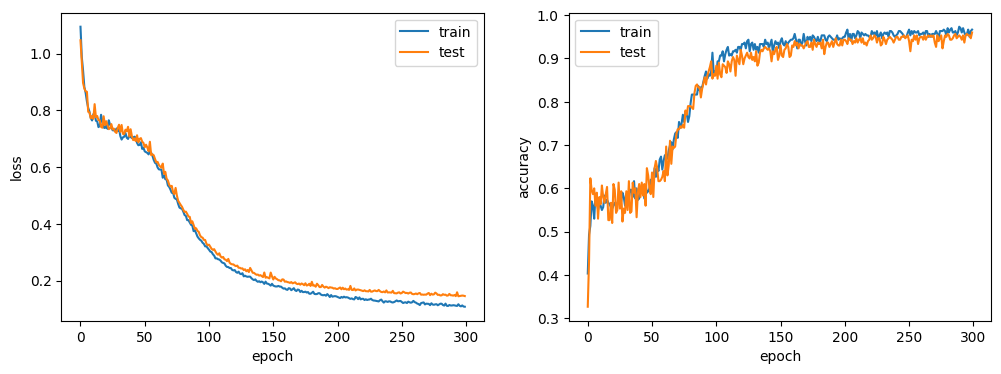

In [8]:
# loss와 accuracy를 시각화

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history["loss"]["train"], label='train')
ax1.plot(history["loss"]["test"], label='test')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(history["acc"]["train"], label='train')
ax2.plot(history["acc"]["test"], label='test')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

plt.show()